## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [20]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sun Mar 31 20:16:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 419.35       Driver Version: 419.35       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8    N/A /  N/A |     69MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
import os
import keras
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
from numba import cuda
import itertools

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [7]:
train, test = keras.datasets.cifar10.load_data()

In [8]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [9]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
def build_mlp(input_shape, output_units=y_train.shape[-1], n_layers=4, num_neurons=[512, 256, 128, 64]):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        else:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layers'+str(i+1))(x)
        
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 2048
OPTIMIZER = ['sgd', 'rmsp', 'adam']
FACTOR = [0.2, 0.35, 0.5]
PATIENCE = [5, 10, 15]

In [12]:
def model_fitting(factor, patience, learning_rate=LEARNING_RATE, optimizer='adam', epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:]):
    
    keras.backend.clear_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    
    model = build_mlp(input_shape=input_shape)
    model.summary()
    
    # Optimizer
    switcher = {'sgd': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'rmsp': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'adag': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}
    optimizer = switcher.get(optimizer)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    # 載入 Callbacks
    reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=factor,
                                                  min_lr=1e-12,
                                                  monitor='val_loss',
                                                  mode='min',
                                                  patience=patience,
                                                  verbose=1)
    
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(x_test, y_test), 
                        shuffle=False,
                        callbacks=[reduce_lr],
                        verbose=1)
    
    sess.close()

    return history

In [13]:
results = {}

for factor, patience, optimizer in itertools.product(FACTOR, PATIENCE, OPTIMIZER):
    
    history = model_fitting(factor=factor, patience=patience, optimizer=optimizer)
    
    name_tag = f'f:{factor}, p:{patience}, o:{optimizer}'
    results[name_tag] = {'train_loss': history.history['loss'],
                         'valid_loss': history.history['val_loss'],
                         'train_acc': history.history['acc'],
                         'valid_acc': history.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
__________

Epoch 47/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.9384 - acc: 0.6907 - val_loss: 1.4949 - val_acc: 0.4825
Epoch 48/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.9377 - acc: 0.6910 - val_loss: 1.4953 - val_acc: 0.4828
Epoch 49/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.9370 - acc: 0.6912 - val_loss: 1.4957 - val_acc: 0.4830

Epoch 00049: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 50/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.9362 - acc: 0.6915 - val_loss: 1.4959 - val_acc: 0.4828
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_____________________________________

Epoch 40/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.3863 - acc: 0.8991 - val_loss: 1.4746 - val_acc: 0.5421
Epoch 41/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.3863 - acc: 0.8991 - val_loss: 1.4747 - val_acc: 0.5421

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
Epoch 42/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.3863 - acc: 0.8992 - val_loss: 1.4748 - val_acc: 0.5421
Epoch 43/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.3863 - acc: 0.8992 - val_loss: 1.4749 - val_acc: 0.5422
Epoch 44/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.3863 - acc: 0.8992 - val_loss: 1.4749 - val_acc: 0.5423
Epoch 45/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.3863 - acc: 0.8992 - val_loss: 1.4750 - val_acc: 0.5423
Epoch 46/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.3863 - a

Epoch 33/50
50000/50000 [==============================] - 3s 60us/step - loss: 0.3696 - acc: 0.9059 - val_loss: 1.5345 - val_acc: 0.5330
Epoch 34/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.3695 - acc: 0.9059 - val_loss: 1.5349 - val_acc: 0.5328

Epoch 00034: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
Epoch 35/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.3694 - acc: 0.9059 - val_loss: 1.5351 - val_acc: 0.5328
Epoch 36/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.3694 - acc: 0.9059 - val_loss: 1.5353 - val_acc: 0.5329
Epoch 37/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.3694 - acc: 0.9059 - val_loss: 1.5355 - val_acc: 0.5329
Epoch 38/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.3694 - acc: 0.9059 - val_loss: 1.5356 - val_acc: 0.5329
Epoch 39/50
50000/50000 [==============================] - 3s 59us/step - loss: 0.3694 - ac

50000/50000 [==============================] - 3s 57us/step - loss: 1.1847 - acc: 0.5959 - val_loss: 1.4977 - val_acc: 0.4774
Epoch 28/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.1688 - acc: 0.6027 - val_loss: 1.4953 - val_acc: 0.4790
Epoch 29/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.1531 - acc: 0.6088 - val_loss: 1.4933 - val_acc: 0.4798
Epoch 30/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.1376 - acc: 0.6148 - val_loss: 1.4916 - val_acc: 0.4813
Epoch 31/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.1222 - acc: 0.6205 - val_loss: 1.4903 - val_acc: 0.4820
Epoch 32/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.1070 - acc: 0.6264 - val_loss: 1.4892 - val_acc: 0.4832
Epoch 33/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.0918 - acc: 0.6322 - val_loss: 1.4884 - val_acc: 0.4827
Epoch 34/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 53us/step - loss: 0.2322 - acc: 0.9455 - val_loss: 1.6316 - val_acc: 0.5358
Epoch 23/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2047 - acc: 0.9553 - val_loss: 1.6722 - val_acc: 0.5355
Epoch 24/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.1808 - acc: 0.9632 - val_loss: 1.7193 - val_acc: 0.5325
Epoch 25/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.1597 - acc: 0.9698 - val_loss: 1.7659 - val_acc: 0.5332
Epoch 26/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.1412 - acc: 0.9752 - val_loss: 1.8161 - val_acc: 0.5313
Epoch 27/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.1273 - acc: 0.9779 - val_loss: 1.8642 - val_acc: 0.5325
Epoch 28/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.1134 - acc: 0.9814 - val_loss: 1.9125 - val_acc: 0.5320
Epoch 29/50
50000/50000 [=====================

Epoch 17/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.3317 - acc: 0.9069 - val_loss: 1.5640 - val_acc: 0.5353
Epoch 18/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.2859 - acc: 0.9256 - val_loss: 1.5993 - val_acc: 0.5320
Epoch 19/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.2563 - acc: 0.9386 - val_loss: 1.6344 - val_acc: 0.5317
Epoch 20/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.2321 - acc: 0.9478 - val_loss: 1.6673 - val_acc: 0.5305
Epoch 21/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.2110 - acc: 0.9547 - val_loss: 1.7020 - val_acc: 0.5302
Epoch 22/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.1919 - acc: 0.9608 - val_loss: 1.7361 - val_acc: 0.5304
Epoch 23/50
50000/50000 [==============================] - 3s 58us/step - loss: 0.1749 - acc: 0.9663 - val_loss: 1.7689 - val_acc: 0.5289
Epoch 24/50
50000/50000 [=========

50000/50000 [==============================] - 3s 55us/step - loss: 1.4463 - acc: 0.4968 - val_loss: 1.5857 - val_acc: 0.4399
Epoch 13/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.4223 - acc: 0.5057 - val_loss: 1.5737 - val_acc: 0.4444
Epoch 14/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.3996 - acc: 0.5145 - val_loss: 1.5628 - val_acc: 0.4479
Epoch 15/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.3779 - acc: 0.5225 - val_loss: 1.5533 - val_acc: 0.4512
Epoch 16/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.3571 - acc: 0.5299 - val_loss: 1.5450 - val_acc: 0.4533
Epoch 17/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.3371 - acc: 0.5365 - val_loss: 1.5373 - val_acc: 0.4558
Epoch 18/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.3178 - acc: 0.5442 - val_loss: 1.5302 - val_acc: 0.4566
Epoch 19/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 56us/step - loss: 1.0436 - acc: 0.6366 - val_loss: 1.5090 - val_acc: 0.4820
Epoch 9/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.9841 - acc: 0.6583 - val_loss: 1.4686 - val_acc: 0.4947
Epoch 10/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.9239 - acc: 0.6824 - val_loss: 1.4565 - val_acc: 0.5068
Epoch 11/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.8775 - acc: 0.6995 - val_loss: 1.4707 - val_acc: 0.4976
Epoch 12/50
50000/50000 [==============================] - 3s 52us/step - loss: 0.8079 - acc: 0.7229 - val_loss: 1.5474 - val_acc: 0.4911
Epoch 13/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.7749 - acc: 0.7351 - val_loss: 1.4699 - val_acc: 0.5136
Epoch 14/50
50000/50000 [==============================] - 3s 61us/step - loss: 0.7078 - acc: 0.7582 - val_loss: 1.5011 - val_acc: 0.5181
Epoch 15/50
50000/50000 [======================

Epoch 4/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.2273 - acc: 0.5691 - val_loss: 1.4067 - val_acc: 0.5024
Epoch 5/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.1239 - acc: 0.6073 - val_loss: 1.3906 - val_acc: 0.5104
Epoch 6/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.0292 - acc: 0.6435 - val_loss: 1.4025 - val_acc: 0.5078
Epoch 7/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.9520 - acc: 0.6720 - val_loss: 1.4390 - val_acc: 0.5077
Epoch 8/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.8893 - acc: 0.6931 - val_loss: 1.4950 - val_acc: 0.4984
Epoch 9/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.8406 - acc: 0.7108 - val_loss: 1.5377 - val_acc: 0.4999
Epoch 10/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.7982 - acc: 0.7238 - val_loss: 1.5405 - val_acc: 0.5035
Epoch 11/50
50000/50000 [===============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 70us/step - loss: 2.4495 - acc: 0.1720 - val_loss: 2.2203 - val_acc: 0.2545
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.0606 - acc: 0.2922 - val_loss: 1.9881 - val_acc: 0.3170
Epoch 3/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.8869 - acc: 0.3454 - val_loss: 1.8726 - val_acc: 0.3465
Epoch 4/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.7871 - acc: 0.3809 - val_loss: 1.8040 - val_acc: 0.3712
Epoch 5/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.7167 - acc: 0.4047 - val_loss: 1.7567 - val_acc: 0.3840
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.6619 - acc: 0.4236 - val_loss: 1.7203 - val_acc: 0.3958
Epoch 7/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.6166 - acc: 0.4408 - val_loss: 1.6912 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.8289 - acc: 0.3589 - val_loss: 1.6466 - val_acc: 0.4121
Epoch 2/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.5313 - acc: 0.4583 - val_loss: 1.5842 - val_acc: 0.4453
Epoch 3/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.4160 - acc: 0.4986 - val_loss: 1.6022 - val_acc: 0.4512
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.3232 - acc: 0.5344 - val_loss: 1.4846 - val_acc: 0.4772
Epoch 5/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.2402 - acc: 0.5634 - val_loss: 1.5678 - val_acc: 0.4515
Epoch 6/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.1756 - acc: 0.5873 - val_loss: 1.4659 - val_acc: 0.4882
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1081 - acc: 0.6124 - val_loss: 1.4641 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.8210 - acc: 0.3632 - val_loss: 1.6309 - val_acc: 0.4286
Epoch 2/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.4798 - acc: 0.4762 - val_loss: 1.4727 - val_acc: 0.4795
Epoch 3/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.3361 - acc: 0.5310 - val_loss: 1.4245 - val_acc: 0.4979
Epoch 4/50
50000/50000 [==============================] - 3s 59us/step - loss: 1.2223 - acc: 0.5721 - val_loss: 1.3917 - val_acc: 0.5148
Epoch 5/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1230 - acc: 0.6068 - val_loss: 1.3757 - val_acc: 0.5155
Epoch 6/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.0304 - acc: 0.6438 - val_loss: 1.3878 - val_acc: 0.5157
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.9559 - acc: 0.6690 - val_loss: 1.3961 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 69us/step - loss: 2.4327 - acc: 0.1615 - val_loss: 2.1774 - val_acc: 0.2473
Epoch 2/50
50000/50000 [==============================] - 2s 50us/step - loss: 2.0155 - acc: 0.2884 - val_loss: 1.9451 - val_acc: 0.3164
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.8507 - acc: 0.3469 - val_loss: 1.8348 - val_acc: 0.3601
Epoch 4/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.7566 - acc: 0.3815 - val_loss: 1.7670 - val_acc: 0.3822
Epoch 5/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.6906 - acc: 0.4039 - val_loss: 1.7219 - val_acc: 0.3972
Epoch 6/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.6390 - acc: 0.4220 - val_loss: 1.6877 - val_acc: 0.4053
Epoch 7/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.5965 - acc: 0.4378 - val_loss: 1.6607 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.8518 - acc: 0.3544 - val_loss: 1.7395 - val_acc: 0.3856
Epoch 2/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.5366 - acc: 0.4564 - val_loss: 1.6583 - val_acc: 0.4258
Epoch 3/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.4150 - acc: 0.5008 - val_loss: 1.5001 - val_acc: 0.4715
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.3245 - acc: 0.5355 - val_loss: 1.6925 - val_acc: 0.4366
Epoch 5/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.2449 - acc: 0.5621 - val_loss: 1.4222 - val_acc: 0.5073
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1685 - acc: 0.5914 - val_loss: 1.4756 - val_acc: 0.4858
Epoch 7/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.0991 - acc: 0.6172 - val_loss: 1.4864 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.8472 - acc: 0.3559 - val_loss: 1.6510 - val_acc: 0.4198
Epoch 2/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.5047 - acc: 0.4684 - val_loss: 1.4889 - val_acc: 0.4796
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.3506 - acc: 0.5244 - val_loss: 1.4220 - val_acc: 0.5002
Epoch 4/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.2342 - acc: 0.5679 - val_loss: 1.3916 - val_acc: 0.5154
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.1296 - acc: 0.6082 - val_loss: 1.3720 - val_acc: 0.5166
Epoch 6/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.0405 - acc: 0.6417 - val_loss: 1.3829 - val_acc: 0.5147
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.9611 - acc: 0.6701 - val_loss: 1.4056 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 72us/step - loss: 2.4509 - acc: 0.1596 - val_loss: 2.1815 - val_acc: 0.2485
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.0208 - acc: 0.2879 - val_loss: 1.9442 - val_acc: 0.3239
Epoch 3/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.8495 - acc: 0.3496 - val_loss: 1.8391 - val_acc: 0.3545
Epoch 4/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.7553 - acc: 0.3842 - val_loss: 1.7750 - val_acc: 0.3774
Epoch 5/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.6897 - acc: 0.4084 - val_loss: 1.7292 - val_acc: 0.3916
Epoch 6/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.6390 - acc: 0.4258 - val_loss: 1.6950 - val_acc: 0.4022
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.5966 - acc: 0.4400 - val_loss: 1.6677 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.8309 - acc: 0.3581 - val_loss: 1.6341 - val_acc: 0.4181
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.5270 - acc: 0.4588 - val_loss: 1.5486 - val_acc: 0.4561
Epoch 3/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.4146 - acc: 0.4999 - val_loss: 1.5534 - val_acc: 0.4612
Epoch 4/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.3186 - acc: 0.5345 - val_loss: 1.5866 - val_acc: 0.4610
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.2468 - acc: 0.5609 - val_loss: 1.4382 - val_acc: 0.4896
Epoch 6/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.1671 - acc: 0.5899 - val_loss: 1.4767 - val_acc: 0.4851
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.0983 - acc: 0.6182 - val_loss: 1.4283 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.8709 - acc: 0.3564 - val_loss: 1.6317 - val_acc: 0.4249
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.4963 - acc: 0.4719 - val_loss: 1.4855 - val_acc: 0.4756
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.3484 - acc: 0.5253 - val_loss: 1.4232 - val_acc: 0.4908
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.2300 - acc: 0.5686 - val_loss: 1.4033 - val_acc: 0.5014
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1272 - acc: 0.6080 - val_loss: 1.4000 - val_acc: 0.5061
Epoch 6/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.0362 - acc: 0.6396 - val_loss: 1.3880 - val_acc: 0.5136
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.9529 - acc: 0.6702 - val_loss: 1.4198 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.4091 - acc: 0.1656 - val_loss: 2.1222 - val_acc: 0.2602
Epoch 2/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.9880 - acc: 0.2933 - val_loss: 1.9247 - val_acc: 0.3222
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.8374 - acc: 0.3483 - val_loss: 1.8232 - val_acc: 0.3592
Epoch 4/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.7509 - acc: 0.3819 - val_loss: 1.7636 - val_acc: 0.3778
Epoch 5/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.6896 - acc: 0.4061 - val_loss: 1.7208 - val_acc: 0.3928
Epoch 6/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.6414 - acc: 0.4241 - val_loss: 1.6881 - val_acc: 0.4013
Epoch 7/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.6007 - acc: 0.4387 - val_loss: 1.6625 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.8411 - acc: 0.3571 - val_loss: 1.6509 - val_acc: 0.4177
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.5316 - acc: 0.4587 - val_loss: 1.6240 - val_acc: 0.4378
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.4257 - acc: 0.4961 - val_loss: 1.5589 - val_acc: 0.4556
Epoch 4/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.3281 - acc: 0.5315 - val_loss: 1.5442 - val_acc: 0.4654
Epoch 5/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.2473 - acc: 0.5643 - val_loss: 1.6003 - val_acc: 0.4515
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1790 - acc: 0.5884 - val_loss: 1.5253 - val_acc: 0.4793
Epoch 7/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.1044 - acc: 0.6167 - val_loss: 1.5329 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.8310 - acc: 0.3649 - val_loss: 1.6533 - val_acc: 0.4288
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.4990 - acc: 0.4713 - val_loss: 1.4852 - val_acc: 0.4767
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.3518 - acc: 0.5231 - val_loss: 1.4191 - val_acc: 0.4987
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.2321 - acc: 0.5661 - val_loss: 1.3885 - val_acc: 0.5120
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1253 - acc: 0.6080 - val_loss: 1.3916 - val_acc: 0.5127
Epoch 6/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.0419 - acc: 0.6379 - val_loss: 1.3859 - val_acc: 0.5145
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.9658 - acc: 0.6670 - val_loss: 1.4233 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 70us/step - loss: 2.5457 - acc: 0.1435 - val_loss: 2.2384 - val_acc: 0.2234
Epoch 2/50
50000/50000 [==============================] - 2s 49us/step - loss: 2.0590 - acc: 0.2739 - val_loss: 1.9683 - val_acc: 0.3192
Epoch 3/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.8681 - acc: 0.3445 - val_loss: 1.8456 - val_acc: 0.3557
Epoch 4/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.7668 - acc: 0.3815 - val_loss: 1.7742 - val_acc: 0.3808
Epoch 5/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.6983 - acc: 0.4079 - val_loss: 1.7266 - val_acc: 0.3927
Epoch 6/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.6454 - acc: 0.4268 - val_loss: 1.6908 - val_acc: 0.4049
Epoch 7/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.6016 - acc: 0.4418 - val_loss: 1.6628 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 70us/step - loss: 1.8320 - acc: 0.3621 - val_loss: 1.6340 - val_acc: 0.4203
Epoch 2/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.5220 - acc: 0.4624 - val_loss: 1.5758 - val_acc: 0.4461
Epoch 3/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.4076 - acc: 0.5045 - val_loss: 1.5204 - val_acc: 0.4671
Epoch 4/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.3178 - acc: 0.5371 - val_loss: 1.5873 - val_acc: 0.4483
Epoch 5/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.2345 - acc: 0.5674 - val_loss: 1.5080 - val_acc: 0.4699
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.1692 - acc: 0.5915 - val_loss: 1.5350 - val_acc: 0.4606
Epoch 7/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.0968 - acc: 0.6192 - val_loss: 1.5183 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.8408 - acc: 0.3557 - val_loss: 1.6486 - val_acc: 0.4322
Epoch 2/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.5013 - acc: 0.4693 - val_loss: 1.4927 - val_acc: 0.4752
Epoch 3/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.3595 - acc: 0.5217 - val_loss: 1.4322 - val_acc: 0.4933
Epoch 4/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.2425 - acc: 0.5641 - val_loss: 1.4022 - val_acc: 0.5039
Epoch 5/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.1384 - acc: 0.6038 - val_loss: 1.3892 - val_acc: 0.5127
Epoch 6/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.0495 - acc: 0.6350 - val_loss: 1.3959 - val_acc: 0.5138
Epoch 7/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.9806 - acc: 0.6596 - val_loss: 1.4041 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 73us/step - loss: 2.3881 - acc: 0.1695 - val_loss: 2.1355 - val_acc: 0.2670
Epoch 2/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.9906 - acc: 0.3038 - val_loss: 1.9319 - val_acc: 0.3292
Epoch 3/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.8295 - acc: 0.3547 - val_loss: 1.8306 - val_acc: 0.3587
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.7398 - acc: 0.3875 - val_loss: 1.7680 - val_acc: 0.3829
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.6783 - acc: 0.4106 - val_loss: 1.7260 - val_acc: 0.4005
Epoch 6/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.6309 - acc: 0.4275 - val_loss: 1.6940 - val_acc: 0.4068
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.5915 - acc: 0.4418 - val_loss: 1.6688 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.7981 - acc: 0.3628 - val_loss: 1.6480 - val_acc: 0.4168
Epoch 2/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.5182 - acc: 0.4609 - val_loss: 1.6242 - val_acc: 0.4340
Epoch 3/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.4012 - acc: 0.5043 - val_loss: 1.5199 - val_acc: 0.4720
Epoch 4/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.3067 - acc: 0.5396 - val_loss: 1.4917 - val_acc: 0.4723
Epoch 5/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.2378 - acc: 0.5669 - val_loss: 1.5855 - val_acc: 0.4647
Epoch 6/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.1667 - acc: 0.5925 - val_loss: 1.4522 - val_acc: 0.4878
Epoch 7/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.0918 - acc: 0.6199 - val_loss: 1.5005 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.8482 - acc: 0.3615 - val_loss: 1.6380 - val_acc: 0.4329
Epoch 2/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.4914 - acc: 0.4727 - val_loss: 1.4722 - val_acc: 0.4763
Epoch 3/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.3405 - acc: 0.5282 - val_loss: 1.4044 - val_acc: 0.5024
Epoch 4/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.2215 - acc: 0.5713 - val_loss: 1.3778 - val_acc: 0.5155
Epoch 5/50
50000/50000 [==============================] - 3s 56us/step - loss: 1.1222 - acc: 0.6065 - val_loss: 1.3696 - val_acc: 0.5176
Epoch 6/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.0284 - acc: 0.6416 - val_loss: 1.3774 - val_acc: 0.5198
Epoch 7/50
50000/50000 [==============================] - 3s 55us/step - loss: 0.9493 - acc: 0.6726 - val_loss: 1.4233 - val_acc

In [16]:
colors = ['#9a0eea', '#15b01a', '#0343df', '#ff81c0', '#653700', 
          '#e50000', '#95d0fc', '#f97306', '#c20078', '#ffff14',
          '#06c2ac', '#00035b', '#d1b26f', '#677a04', '#ae7181',
          '#ffb07c', '#b1916e', '#21fc0d', '#a24857', '#9c6da5', 
          '#de0c62', '#017b92', '#bff128', '#fffe71', '#f7022a',
          '#bd6c48', '#3b719f']

def plotting(results, color_bar=colors):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    for i, cond in enumerate(results.keys()):

        epochs = range(1, len(results[cond]['train_loss']) + 1)

        ax1.plot(epochs, results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
        ax1.plot(epochs, results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
        
        ax2.plot(epochs, results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
        ax2.plot(epochs, results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
        
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_title('Loss', fontsize=25)
    ax1.legend()
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_title('Accuracy', fontsize=25)
    ax2.legend()
    plt.show()

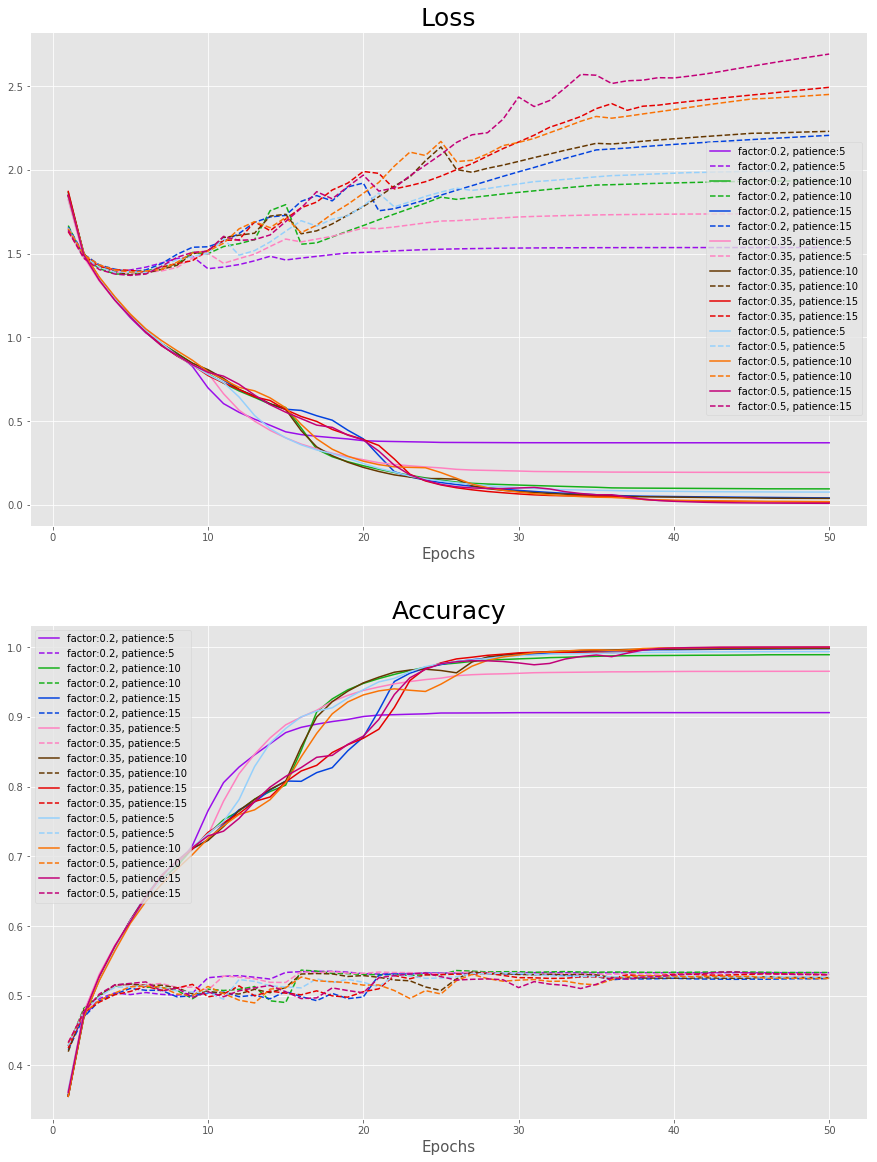

In [17]:
plotting(results)

In [19]:
cuda.select_device(0)
cuda.close()